<a href="https://www.kaggle.com/mickwonjae/petfinder-adoption-speed-prediction-with-catboost?scriptVersionId=87101844" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd 
from catboost import CatBoostClassifier
import seaborn as sns

In [2]:
train = pd.read_csv("../input/petfinder-adoption-prediction/train/train.csv")
train.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [3]:
test = pd.read_csv("../input/petfinder-adoption-prediction/test/test.csv")
test.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt
0,2,Dopey & Grey,8,266,266,1,2,6,7,1,...,2,1,2,0,41326,2ece3b2573dcdcebd774e635dca15fd9,0,"Dopey Age: 8mths old Male One half of a pair, ...",e2dfc2935,2.0
1,2,Chi Chi,36,285,264,2,1,4,7,2,...,1,2,1,0,41326,2ece3b2573dcdcebd774e635dca15fd9,0,"Please note that Chichi has been neutered, the...",f153b465f,1.0
2,2,Sticky,2,265,0,1,6,7,0,2,...,2,1,1,200,41326,e59c106e9912fa30c898976278c2e834,0,"Sticky, named such because of his tendency to ...",3c90f3f54,4.0
3,1,Dannie & Kass [In Penang],12,307,0,2,2,5,0,2,...,1,1,2,0,41326,e59c106e9912fa30c898976278c2e834,0,Dannie and Kass are mother and daughter. We en...,e02abc8a3,5.0
4,2,Cuddles,12,265,0,1,2,3,7,2,...,1,1,1,0,41326,e59c106e9912fa30c898976278c2e834,0,"Extremely cuddly cat, hence the origin of his ...",09f0df7d1,5.0


In [4]:
sample_submission = pd.read_csv("../input/petfinder-adoption-prediction/test/sample_submission.csv")
sample_submission.head()

,PetID,AdoptionSpeed
0,e2dfc2935,0
1,f153b465f,0
2,3c90f3f54,0
3,e02abc8a3,0
4,09f0df7d1,0


In [5]:
categorical_columns = ["Type", "Breed1", "Breed2", "Gender", "Color1", "Color2", "Color3", "MaturitySize", "Vaccinated", "Dewormed", "Sterilized", "Health", "State"]
numerical_columns = ["Age", "Fee", "VideoAmt", "PhotoAmt"]

## Distributions

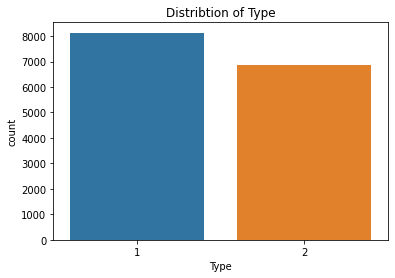

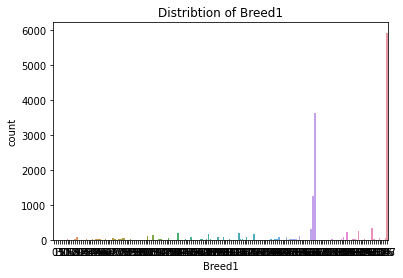

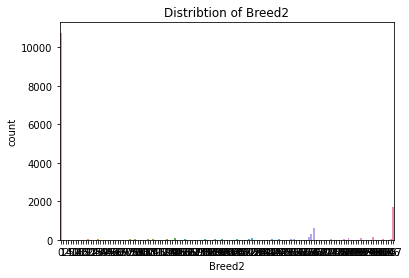

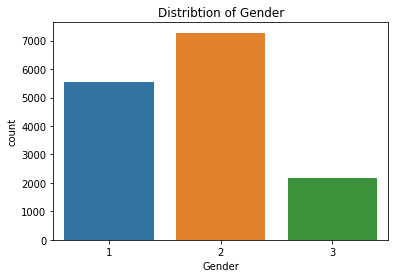

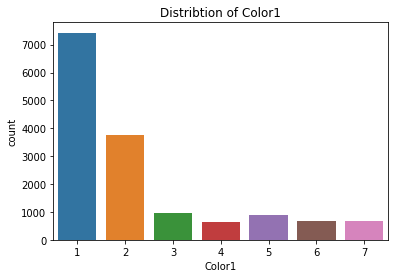

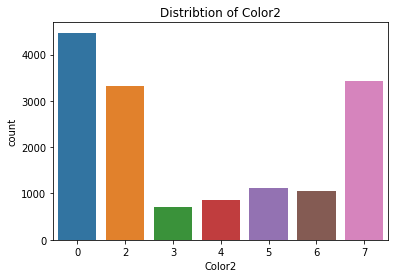

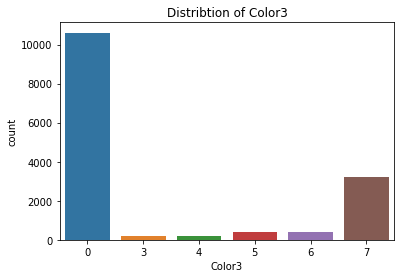

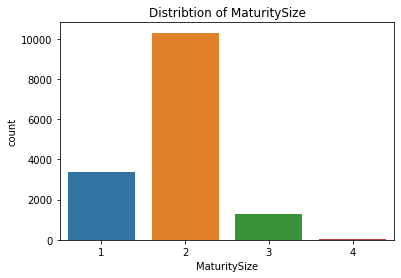

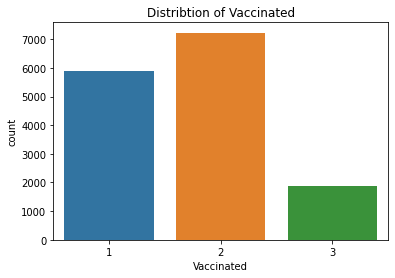

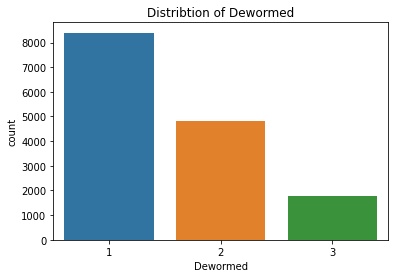

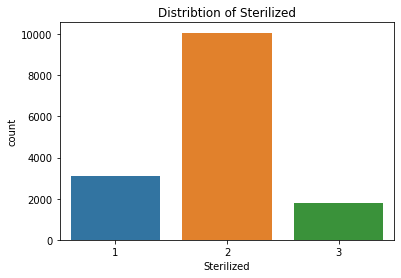

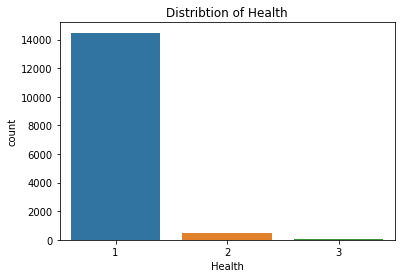

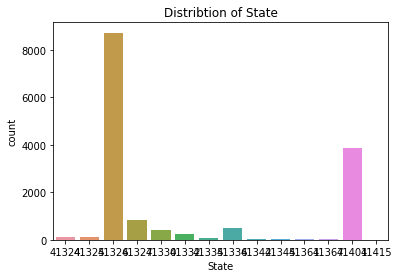

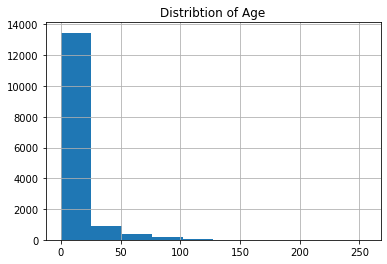

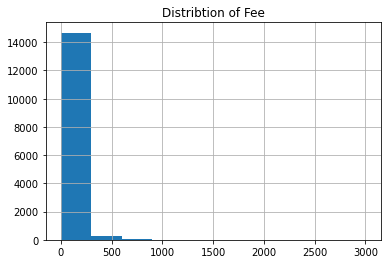

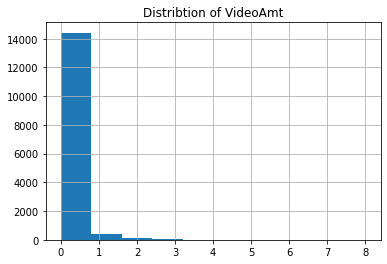

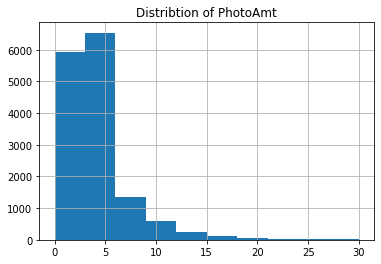

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
for i in range(len(categorical_columns)):
    sns.countplot(x=categorical_columns[i], data=train)
    plt.title("Distribtion of %s"%(categorical_columns[i]))
    plt.show()
for i in range(len(numerical_columns)):
    train[numerical_columns[i]].hist()
    plt.title("Distribtion of %s"%(numerical_columns[i]))
    plt.show()

## Preprocessing

In [12]:
data = pd.DataFrame()
data = data.append(train)
data = data.append(test)
dfs = []
for i in range(len(categorical_columns)):
    df = pd.get_dummies(data[categorical_columns[i]])
    df.columns = [categorical_columns[i] + "_" + str(column) for column in df.columns]
    dfs.append(df)
numeric_df = data[numerical_columns]
numeric_df = (numeric_df - numeric_df.mean()) / numeric_df.std()
dfs.append(numeric_df)
df = pd.concat(dfs, axis=1)
train_features = df.iloc[:len(train)]
test_features = df.iloc[len(train):]

## Train Validation Split

In [13]:
from sklearn.model_selection import train_test_split
train_targets = train["AdoptionSpeed"]
X_train, X_val, y_trian, y_val = train_test_split(train_features, train_targets, test_size=0.1)
X_train.shape, X_val.shape, y_trian.shape, y_val.shape

((13493, 390), (1500, 390), (13493,), (1500,))

## Modeling

In [14]:
cat_params = {
    "iterations": 15000,
    "learning_rate": 0.03,
    "depth": 7,
    "verbose": 1000,
    'od_wait': 1000,
    'eval_metric': 'Accuracy',
}
model = CatBoostClassifier(**cat_params)
model.fit(X_train, y_trian, eval_set=(X_val, y_val))

0:	learn: 0.3646335	test: 0.3480000	best: 0.3480000 (0)	total: 26.8ms	remaining: 6m 42s
1000:	learn: 0.5291633	test: 0.3866667	best: 0.3873333 (830)	total: 26.3s	remaining: 6m 8s
2000:	learn: 0.5822278	test: 0.3893333	best: 0.3933333 (1808)	total: 52.4s	remaining: 5m 40s
3000:	learn: 0.6202475	test: 0.3933333	best: 0.3953333 (2462)	total: 1m 18s	remaining: 5m 12s
4000:	learn: 0.6547840	test: 0.3920000	best: 0.3960000 (3142)	total: 1m 44s	remaining: 4m 48s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.396
bestIteration = 3142

Shrink model to first 3143 iterations.


## Submission

In [10]:
y_pred = model.predict(test_features)
y_pred.shape

(3972, 1)

In [11]:
sample_submission["AdoptionSpeed"] = y_pred
sample_submission.to_csv("submission.csv", index=False)
sample_submission.head()

,PetID,AdoptionSpeed
0,e2dfc2935,4
1,f153b465f,4
2,3c90f3f54,2
3,e02abc8a3,4
4,09f0df7d1,4
